In [55]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
import xarray as xr
import pandas as pd
import pickle
import netCDF4 as netcdf
from scipy import interpolate, signal
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve as astropy_convolve
from scipy.signal import convolve as scipy_convolve
from CoreBx_funcs import *
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

drive, computername = which_computer()
print('Working on ',computername)

# These commands choose fonts that are editable in svg format
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# colors
dblue = '#1f77b4'
red3 = ['#fee0d2','#fc9272','#de2d26']
# oranges from ColorBrewer https://colorbrewer2.org/#type=sequential&scheme=PuBu&n=5
cols=['#feedde','#fdbe85','#fd8d3c','#e6550d','#a63603']
blue5=['#f1eef6','#bdc9e1','#bdc9e1','#2b8cbe','#045a8d']
green5=['#edf8e9','#bae4b3','#74c476','#31a354','#006d2c']
purple5 = ['#f2f0f7','#cbc9e2','#9e9ac8','#756bb1','#54278f']

# This is the colormap made in SurferClr2Cmap.ipynb from NorthCore_ElevationShader_v2.clr
fp = open('cmap_ncb.pkl', 'rb')
cmap_ncb = pickle.load(fp)
fp.close()

# This makes NaN gray
tcmap=cmap_ncb
tcmap.set_bad(color='darkgray')

# This is the difference color map
dcmap = cm.seismic.copy()
dcmap.set_bad(color='darkgray')

# load in map offsets
with open('offsets.yml') as f:
    offset = yaml.safe_load(f)
offset = np.array(offset)
print(offset)

# Dates for DEMs
dates = ([\
         "2019-08-30",\
         "2019-09-12",\
         "2019-10-11",\
         "2019-11-26",\
         "2020-02-09",\
         "2020-04-09",\
         "2020-08-05",\
         "2020-08-09",\
         "2020-09-28",\
         "2021-05-30"])

dem_path = drive+'crs/proj/2019_DorianOBX/Dorian_paper_analyses/rotated_dems/'

# # these offsets are the mean anomaly relative to the 10-map mean per Analyze_rotated_stable_points_refac
# offset = np.array([0.00168195,  0.02229009, -0.02397204, -0.01150765, -0.07320715, -0.02726184,
#  -0.03547332, -0.02953579, -0.02719979,  0.00756222])

MHHW = 0.4 #elevation of MHHW per VDATUM

# Read in a dict that defines the rotated "island" coordinate system
r = yaml2dict('small_island_box.yml')
print('Dict for island rotation: ',r)

# read in the multi-map .nc file
fn = r['name']+'_clipped.nc'
dsa = xr.open_dataset(dem_path+fn)
dsaa = np.squeeze(dsa.to_array())
nmaps,ncross,nalong=np.shape(dsaa)
print('nmaps, ncross, nalong: ',nmaps,ncross,nalong)

# Correct for uniform offsets
for i in range(0, nmaps):
    dsaa[i,:,:] = dsaa[i,:,:] - offset[i]
    
aug = np.squeeze(np.array(dsaa[0,:,:]))
sep = np.squeeze(np.array(dsaa[1,:,:]))
oct = np.squeeze(np.array(dsaa[2,:,:]))
nov = np.squeeze(np.array(dsaa[3,:,:]))

    
# Read in lidar
lidar_fn = dem_path+r['name']+'_Oct_lidar_gnd.nc'
ds_gnd = xr.open_dataset(lidar_fn)
gnda = np.squeeze(np.array(ds_gnd.to_array()))

lidar_fn2 = dem_path+r['name']+'_Oct_lidar_canopy.nc'
ds_can = xr.open_dataset(lidar_fn2)
cana = np.squeeze(np.array(ds_can.to_array()))

Working on  IGSAGIEGWSCSH10
[ 0.00168195  0.02229009 -0.02397204 -0.01150765 -0.07320715 -0.02726184
 -0.03547332 -0.02953579 -0.02719979  0.00756222]
Dict for island rotation:  {'name': 'ncorebx_small', 'e0': 383520.0, 'n0': 3860830.0, 'xlen': 25000.0, 'ylen': 1200.0, 'dxdy': 1.0, 'theta': 42.0}
nmaps, ncross, nalong:  10 1200 25000


(1200, 25000)


(0.0, 2700.0, 0.0, 1000.0)

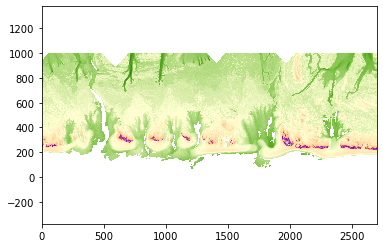

In [29]:
print(gnda.shape)
plt.pcolor(ds_gnda[200:,18500:21200], cmap=cmap_ncb)
plt.axis('equal')

In [43]:
# Smooth
kernel = Gaussian2DKernel(x_stddev=4)
print('Size of kernel: ', kernel.shape)
# fill holes with smoothed surface
from astropy.convolution import interpolate_replace_nans
gndas = interpolate_replace_nans(gnda, kernel)
#gndas = astropy_convolve(gnda, kernel, boundary='fill', fill_value=np.nan)

Size of kernel:  (33, 33)


(0.0, 3000.0, 0.0, 1000.0)

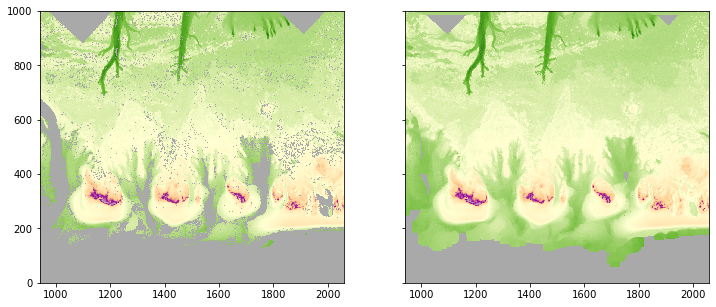

In [44]:
fig, ax = plt.subplots(1,2,sharey=True, figsize=(12,5))
ax[0].pcolormesh(gnda[200:,18000:21000], cmap=cmap_ncb)
ax[0].axis('equal')
ax[1].pcolormesh(gndas[200:,18000:21000], cmap=cmap_ncb)
ax[1].axis('equal')

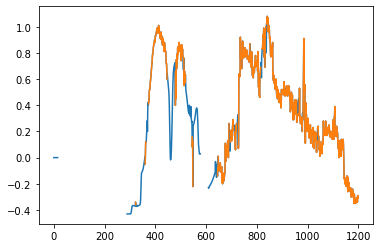

In [51]:
p = gnda[:,18000+1750]
ps = gndas[:,18000+1750]
plt.plot(ps)
plt.plot(p)

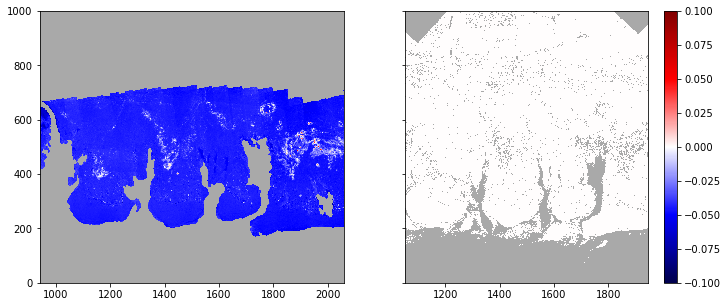

In [68]:
fig, ax = plt.subplots(1,2,sharey=True, figsize=(12,5))
pc0 = ax[0].pcolormesh((oct[200:,18000:21000]-.276)-gndas[200:,18000:21000], cmap=dcmap)
ax[0].axis('equal')
pc1 = ax[1].pcolormesh(gnda[200:,18000:21000]-gndas[200:,18000:21000], cmap=dcmap)
ax[1].axis('equal')
plt.colorbar(pc1)

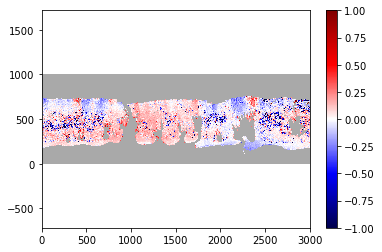

In [84]:
oct_cana = oct-cana
plt.pcolormesh( oct_cana[200:,18000:21000], cmap=dcmap, vmin=-1, vmax=1)
plt.axis('equal')
plt.colorbar()

In [79]:
np.nanmean(oct_cana)

-0.00035455488

0.015879635


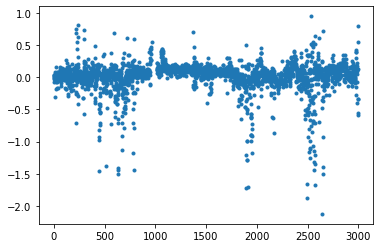

In [87]:
plt.plot(oct_cana[750,18000:21000],'.')
print(np.nanmean(oct_cana[750,18000:21000]))